Making stimuli
==============

Silent substitution stimuli typically take the form of pulses or temporal modulations of photoreceptor-specific contrast presented against a background spectrum to which an observer has adapted. The background spectrum serves to maintain a set pattern of photoreceptor activations and the modulation spectrum increases activation of the targeted photoreceptor(s) without altering activation of the others. 

![](../../img/ss_example.svg)

The example above describes, for a 5-primary stimulation device, a pair of silent substitution spectra where melanopsin receives 250% modulation and the cones are silent. From left to right are shown the spectral power distributions, chromaticity coordinates, and photoreceptor-specific irradiances for the background and modulation spectra. Rods appear to be modulated, too, but in this example both spectra are ~2000 lux, so we expect rods to be saturated and reason that it is safe to ignore them. We can see also that both spectra have the same chromaticity. 

Arriving at a solution such as this requires groundwork. First, we need a [forward model of our stimulation device](03a_stimulation_devices.ipynb) that will predict the spectral output for any combination of settings. With that in place, we review the research goals: What photoreceptor(s) are we trying to isolate? How much contrast do we want to achieve? Do we wish to enforce any particular constraints on our stimuli? When we know the answer to these questions, we can formalise the problem and look for a solution. Two ways of doing this, each of which has unique advantages, are with numerical optimization and linear algebra.


Numerical optimization
----------------------

Silent substitution can be approached as a [constrained numerical optimization](https://en.wikipedia.org/wiki/Constrained_optimization) problem of the form:

\begin{equation}
\begin{array}{rrclcl}
& \underset{x \in \mathbb{R}^{n}}{\text{minimize}}
&  f(x) \\
& \text{subject to}
& g^{L} \le g(x) \le g^{U} \\
& & x^{L} \le x \le x^{U} ,
\end{array}
\end{equation}

where $x \in \mathbb{R}^{n}$ are the optimization variables (the device settings) whose lower and upper bounds, $x^{L}$ and $x^{U}$, are between 0 and 1 to ensure that the solution is within the gamut of the device, $f(x)$ is the objective function that aims to maximise contrast of the target photoreceptor(s), and $g(x)$ is a function that calculates contrast for the silenced photoreceptor(s), where $g^{L}$ and $g^{U}$ should be zero. In all cases, $x$ is a vector containing the weights for the LED settings. 

Conveniently, *PySilSub* encapsulates this optimisation problem in a `SilentSubstitutionProblem` class that inherits everything from `StimulationDevice`. We can instantiate it in the same way, but this time including further information to condition the problem. As a basic demonstration, suppose we have calibration data for a linear, 8-bit, 5-primary stimulation system and that we want to find the settings for two spectra that will yield 250% contrast for melanopsin. 

In [1]:
import pandas as pd

from pysilsub.problem import SilentSubstitutionProblem

# Load the calibration data
spds = pd.read_csv(
    '../../data/BCGAR_5_Primary_8_bit_linear.csv', 
    index_col=['Primary','Setting'])
spds.columns = pd.Int64Index(spds.columns.astype(int))
spds.columns.name = 'Wavelength'

# List of colors for the primaries
colors = ['blue', 'cyan', 'green', 'orange', 'red'] 

spds

Wavelength            380       381       382       383       384       385  \
Primary Setting                                                               
0       0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        7        0.000068  0.000071  0.000062  0.000068  0.000055  0.000055   
        15       0.000137  0.000141  0.000123  0.000136  0.000109  0.000111   
        23       0.000205  0.000212  0.000185  0.000204  0.000164  0.000166   
        31       0.000274  0.000282  0.000247  0.000272  0.000219  0.000222   
...                   ...       ...       ...       ...       ...       ...   
4       223      0.003027  0.003555  0.003159  0.003563  0.002712  0.002951   
        231      0.003135  0.003682  0.003271  0.003690  0.002808  0.003056   
        239      0.003243  0.003809  0.003384  0.003817  0.002905  0.003162   
        247      0.003351  0.003936  0.003497  0.003944  0.003002  0.003267   
        255      0.003459  0.004063  0.003610  0.004071  0.003099  0.003373   

Wavelength            386       387       388       389  ...       771  \
Primary Setting                                          ...             
0       0        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        7        0.000064  0.000051  0.000063  0.000074  ...  0.000037   
        15       0.000127  0.000101  0.000126  0.000148  ...  0.000074   
        23       0.000191  0.000152  0.000189  0.000222  ...  0.000111   
        31       0.000254  0.000202  0.000252  0.000296  ...  0.000148   
...                   ...       ...       ...       ...  ...       ...   
4       223      0.002827  0.002159  0.003197  0.003623  ...  0.001990   
        231      0.002928  0.002237  0.003311  0.003753  ...  0.002061   
        239      0.003029  0.002314  0.003426  0.003882  ...  0.002132   
        247      0.003130  0.002391  0.003540  0.004011  ...  0.002203   
        255      0.003231  0.002468  0.003654  0.004141  ...  0.002274   

Wavelength            772       773       774       775       776       777  \
Primary Setting                                                               
0       0        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        7        0.000039  0.000040  0.000039  0.000039  0.000039  0.000036   
        15       0.000077  0.000080  0.000079  0.000078  0.000078  0.000072   
        23       0.000116  0.000120  0.000118  0.000117  0.000117  0.000108   
        31       0.000154  0.000160  0.000158  0.000157  0.000156  0.000144   
...                   ...       ...       ...       ...       ...       ...   
4       223      0.002227  0.002264  0.002182  0.002558  0.002361  0.002268   
        231      0.002306  0.002345  0.002259  0.002649  0.002446  0.002349   
        239      0.002386  0.002426  0.002337  0.002741  0.002530  0.002430   
        247      0.002465  0.002507  0.002415  0.002832  0.002614  0.002511   
        255      0.002545  0.002587  0.002493  0.002923  0.002699  0.002592   

Wavelength            778       779       780  
Primary Setting                                
0       0        0.000000  0.000000  0.000000  
        7        0.000032  0.000038  0.000037  
        15       0.000064  0.000075  0.000075  
        23       0.000096  0.000113  0.000112  
        31       0.000128  0.000151  0.000149  
...                   ...       ...       ...  
4       223      0.001905  0.002162  0.002360  
        231      0.001973  0.002239  0.002445  
        239      0.002041  0.002316  0.002529  
        247      0.002109  0.002394  0.002613  
        255      0.002177  0.002471  0.002698  

[165 rows x 401 columns]

We can pass these data to `SilentSubstitutionProblem`&mdash;just like we did with `StimulationDevice`&mdash;only this time we specify which photoreceptors to ignore, which of them to silence, and which to isolate.

In [2]:
from pysilsub.problem import SilentSubstitutionProblem as SSP

ssp = SSP(
    resolutions=[255]*5,  # Five 8-bit primaries
    colors=colors,  # Colors of the LEDs
    spds=spds,  # The calibration data
    spd_binwidth=1,  # SPD wavelength binwidth
    ignore=['R'],  # Ignore rods
    silence=['S', 'M', 'L'],  # Silence S-, M-, and L-cones
    isolate=['I'],  # Isolate melanopsin
    target_contrast=2.5,  # Aim for 250% contrast 
    name='BCGAR (8-bit, linear)'  # Description of device
) 

Because `StimulationDevice` is the base class we can do all the cool things described [here](03a_stimulation_devices.ipynb), like plotting the spds and the gamut of the device. But lets get straight on to the optimisation.

As a general note, numerical optimisation is a big old topic and there are many algorithms available, each with their own idiosynchrasies. At present, *PySilSub* does not know the best algorithm for your stimulation device and research goals, nor does it unite different algorithms under a common calling syntax. It simply encapsulates your problem in the form of ready made functions that you can pass to an optimiser. So, If you are new to optimisation in Python, it's worth investing a bit of time to learn the basics. [This article](https://realpython.com/python-scipy-cluster-optimize/) is a good place to start. 

Though not the only option, Scipy's `optimize` module is comprehensive and contains a range of methods for local and global optisation with linear or nonlinear constraints. In this case we will use the [SLSQP](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/optimize.minimize-slsqp.html) solver with Scipy's `optimize.minimize` function. 

In [3]:
from scipy.optimize import minimize

# Initial guess for optimisation variables
x0 = ssp.initial_guess_x0()

# The silencing constraint is an equality
# constraint defined in the standard scipy 
# format. 
constraints = {
    'type': 'eq',
    'fun': ssp.silencing_constraint,
    'ftol': 1e-07
    }

# Perform the optimisation
result = minimize(
    fun=ssp.objective_function,
    x0=x0,
    method='SLSQP',
    bounds=ssp.bounds,
    constraints=constraints,
    tol=1e-07
)

result

     fun: 2.279907827621543e-09
     jac: array([ -1.28309478e-03,  -2.10522508e-03,  -1.71888112e-03,
        -2.80492131e-04,  -4.39255649e-05,   3.83081597e-04,
         6.48058128e-04,   4.55524698e-04,   8.08864456e-05,
         1.09967345e-05])
 message: 'Optimization terminated successfully'
    nfev: 576
     nit: 49
    njev: 49
  status: 0
 success: True
       x: array([  1.68469625e-02,   1.98733879e-03,   0.00000000e+00,
         1.98765116e-01,   1.23914887e-02,   1.93123512e-19,
         0.00000000e+00,   1.49632233e-01,   5.19820961e-02,
         9.92091592e-01])

Printed above is the result of the optimisation in Scipy's standard `OptimizationResult` format. The low value of `fun` indicates that we are very close to the target contrast of 250%. Unsurprisingly, what we actually need is `result.x`. Visualising the result is straight forward.

	Background luminance: 2132.538596245848
	Modulation luminance: 2132.5691877683666
	Background xy: [ 0.55300995  0.39587685]
	Modulation xy: [ 0.55296001  0.39592361]


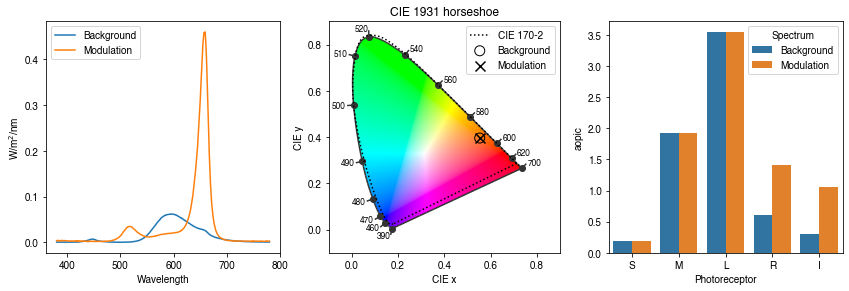

In [4]:
result_fig = ssp.plot_ss_result(result.x)
result_fig.savefig('../../img/ss_example.svg')

Voila&mdash;a pair of silent substitution spectra. Converting the optimisation result to 8-bit settings for the stimulation device is easy.

In [5]:
bg_settings = ssp.weights_to_settings(result.x[:5])
bg_settings

[4, 0, 0, 50, 3]

In [6]:
mod_settings = ssp.weights_to_settings(result.x[5:])
mod_settings

[0, 0, 38, 13, 252]

All being well, if we pass these settings to the stimulation device it will produce these two spectra. But see here for various challanges and caveats. 

Linear algebra
--------------

Silent substitution problems can also be solved with linear algebra. As a worked example, suppose that we now want to isolate S-cones.

In [7]:
ssp.isolate = ['S']
ssp.silence = ['M', 'L', 'I']

For a background spectrum we will take the mixture of all primaries at half-max power. As we'll be doing some matrix algebra involving the individual primaries, in this case we don't want to sum the predicted spectra.

In [8]:
bg_settings = [.5, .5, .5, .5, .5]
bg_spds = ssp.predict_multiprimary_spd(bg_settings, nosum=True)
bg_spds

Primary            0         1         2         3         4
Wavelength                                                  
380         0.001098  0.000856  0.001115  0.001842  0.001736
381         0.001134  0.000933  0.001191  0.002067  0.002040
382         0.000991  0.000838  0.001198  0.001945  0.001812
383         0.001091  0.000828  0.001231  0.001945  0.002044
384         0.000879  0.000745  0.001003  0.001673  0.001556
...              ...       ...       ...       ...       ...
776         0.000625  0.000533  0.000710  0.002349  0.001355
777         0.000577  0.000525  0.000693  0.002305  0.001301
778         0.000516  0.000398  0.000562  0.002146  0.001093
779         0.000605  0.000539  0.000733  0.002114  0.001240
780         0.000600  0.000559  0.000826  0.002350  0.001354

[401 rows x 5 columns]

Next, we'll be needing the spectral sensitivities for the photoreceptors.

In [9]:
from pysilsub.CIE import get_CIES026

sss = get_CIES026()
sss

Photoreceptor    S         M         L             R             I
Wavelength                                                        
380            0.0  0.000000  0.000000  5.890000e-04  9.181600e-04
381            0.0  0.000000  0.000000  6.650000e-04  1.045600e-03
382            0.0  0.000000  0.000000  7.520000e-04  1.178600e-03
383            0.0  0.000000  0.000000  8.540000e-04  1.322800e-03
384            0.0  0.000000  0.000000  9.720000e-04  1.483800e-03
...            ...       ...       ...           ...           ...
776            0.0  0.000002  0.000024  1.730000e-07  2.550000e-08
777            0.0  0.000002  0.000023  1.640000e-07  2.420000e-08
778            0.0  0.000002  0.000021  1.550000e-07  2.290000e-08
779            0.0  0.000002  0.000020  1.470000e-07  2.170000e-08
780            0.0  0.000001  0.000019  1.390000e-07  2.050000e-08

[401 rows x 5 columns]

The dot product of these matrices, which we will call the primary-to-receptor matrix, contains the *a*-opic irradiances for each primary component of the background spectrum.

In [10]:
p2r_matrix = sss.T.dot(bg_spds)
p2r_matrix

Primary               0         1         2         3         4
Photoreceptor                                                  
S              3.580009  2.453689  0.211358  0.095264  0.057067
M              0.627573  1.355843  3.573256  4.683028  0.156777
L              0.435727  0.873636  2.915142  8.686473  0.853310
R              1.730730  2.965132  3.638927  1.288265  0.076642
I              2.094721  3.520715  2.841600  0.509312  0.069365

The inverse of the primary-to-receptor matrix is ultimately what will help us find a solution.

In [11]:
import numpy as np

inv_p2r_matrix = pd.DataFrame(
    np.linalg.inv(p2r_matrix.values),
    p2r_matrix.columns, 
    p2r_matrix.index)
inv_p2r_matrix.T

Primary               0         1         2         3         4
Photoreceptor                                                  
S              0.473797 -0.279487 -0.002424  0.026572 -0.218010
M             -0.159332  0.340021 -0.286409  0.502356 -4.402157
L             -0.001803 -0.037472  0.015329 -0.059770  1.767262
R              0.993080 -1.654925  1.342032 -0.855885  5.315177
I             -1.104764  1.750941 -1.022070  0.523675 -3.067724

Now, the dot product of the inverse primary-to-receptor matrix and a vector of requested photoreceptor contrasts will give the weights for each primary that must be added to the background spectrum to achieve the specified contrast.

In [12]:
requested_contrasts = np.array([.5, 0., 0., 0., 0.])  # S-cones, 50%
modulation_weights = inv_p2r_matrix.dot(requested_contrasts)
modulation_weights

Primary
0    0.236898
1   -0.139744
2   -0.001212
3    0.013286
4   -0.109005
dtype: float64

Finally, we add the modulation weights to the background in order to obtain the settings for a modulation spectrum.

In [13]:
mod_settings = (bg_settings + modulation_weights).to_list()
mod_settings

[0.7368983602866317,
 0.360256442034834,
 0.4987878800748165,
 0.5132862470449632,
 0.39099496157526487]

Obviously, these values must all be between zero and one for the solution to be valid, which in this case they are. As before, we can visualise the solution.

	Background luminance: 8996.204095646926
	Modulation luminance: 8996.237621854996
	Background xy: [ 0.36478141  0.31094694]
	Modulation xy: [ 0.3535229   0.29324481]


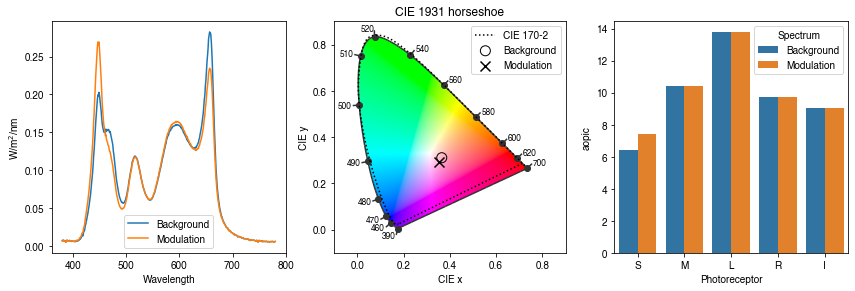

In [14]:
result_fig = ssp.plot_ss_result(bg_settings + mod_settings)